[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/ninarina12/NX-School-2023/blob/main/AI-ML_Tutorial.ipynb)

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm import tqdm

### Use ChatGPT to make a generator for image data

#### ChatGPT Prompt:
Write a python script using numpy arrays that generates $N \times N$ images with 1-5 randomly-placed circles of a user-provided radius, all of which either touch or overlap one another. Ensure that the first circle is placed within the center $N/2 \times N/2$ pixels of the image.

In [3]:
def generate_image(N, num_circles, radius):
    if num_circles < 1 or num_circles > 5:
        raise ValueError("Number of circles should be between 1 and 5.")

    # Create an empty NxN image
    image = np.zeros((N, N))

    # Function to generate a circle within an image
    def draw_circle(img, center, rad):
        Y, X = np.ogrid[:img.shape[0], :img.shape[1]]
        dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
        mask = dist_from_center <= rad
        img[mask] += 1

    # Generate the first circle in the center N/2 x N/2 pixels
    center_x = np.random.randint(N/4, 3*N/4)
    center_y = np.random.randint(N/4, 3*N/4)
    centers = [(center_x, center_y)]
    draw_circle(image, centers[0], radius)

    for _ in range(1, num_circles):
        # Randomly select an existing circle
        ref_center = centers[np.random.choice(len(centers))]

        # Generate a random angle to place the new circle
        angle = 2 * np.pi * np.random.rand()

        # Calculate the center of the new circle based on the angle and 2*radius distance
        new_center_x = ref_center[0] + 2 * radius * np.cos(angle)
        new_center_y = ref_center[1] + 2 * radius * np.sin(angle)
        
        # Handle boundaries
        new_center_x = min(max(radius, new_center_x), N - radius)
        new_center_y = min(max(radius, new_center_y), N - radius)

        centers.append((new_center_x, new_center_y))
        draw_circle(image, (new_center_x, new_center_y), radius)

    return image

### Write custom functions to generate diffraction patterns from generated images

In [4]:
def fourier_transform(obj): 
    return np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(obj)))

def calculate_diffraction_pattern(obj, lam=1e3):
    diff = np.abs(fourier_transform(obj))**2
    diff /= diff.max()
    return np.random.poisson(lam*diff)

We also write some custom functions for plotting the object and diffraction pattern using the `matplotlib` library.

In [5]:
def plot_object_and_pattern(obj, diff, label=0):
    fig, ax = plt.subplots(1,3, figsize=(6.25,3), gridspec_kw={'width_ratios': [1,1,0.05]})
    fig.subplots_adjust(wspace=0.1)
    
    cmap = plt.cm.bone
    vmax = 10**np.round(np.log10(diff.max()))
    norm = mpl.colors.LogNorm(vmin=1., vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

    ax[0].imshow(obj, origin='lower', cmap='gray')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    
    if label:
        ax[0].text(0.9, 0.1, 'n = ' + str(label), color='white', ha='right', va='bottom', transform=ax[0].transAxes)

    ax[1].imshow(diff, origin='lower', cmap=cmap, norm=norm)
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    plt.colorbar(sm, cax=ax[2])
    return fig

def plot_pattern_grid(diffs):
    fig, ax = plt.subplots(4,5, figsize=(8,8), gridspec_kw={'width_ratios': [1]*4 + [0.05]})
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    axes = ax[:,:-1].ravel()

    indices = np.random.randint(len(diffs), size=16)

    cmap = plt.cm.bone
    vmax = 10**np.round(np.log10(diffs.max()))
    norm = mpl.colors.LogNorm(vmin=1., vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

    for i, index in enumerate(indices):
        axes[i].imshow(diffs[index], origin='lower', cmap=cmap, norm=norm)
        axes[i].set_xticks([])
        axes[i].set_yticks([])

    for i in range(3):
        ax[i,-1].remove()

    plt.colorbar(sm, cax=ax[-1,-1])
    return fig

### Plot a randomly-generated example and its diffraction pattern

In [6]:
# Generate real-space image
N = 256
num_circles = 3
radius = 4
obj = generate_image(N, num_circles, radius)

# Calculate diffraction pattern
lam = 1e3
diff = calculate_diffraction_pattern(obj, lam)

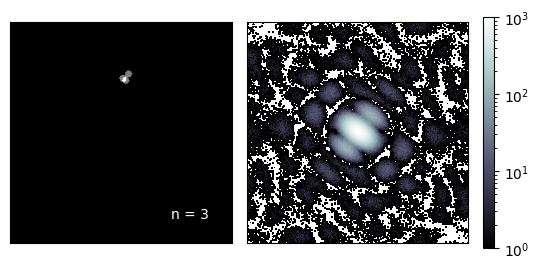

In [7]:
fig = plot_object_and_pattern(obj, diff, num_circles)

In [8]:
num_images = 1000
objs = np.zeros((num_images, N, N))
diffs = np.zeros_like(objs)
targets = np.zeros((num_images,), dtype=int)

for i in tqdm(range(num_images), desc="Generating image data"):
    # Randomly select number of circles to generate
    num_circles = np.random.randint(1,6)
    targets[i] = num_circles - 1
    
    # Generate real-space image
    objs[i] = generate_image(N, num_circles, radius)
    
    # Calculate diffraction pattern
    diffs[i] = calculate_diffraction_pattern(objs[i], lam)

Generating data: 100%|█████████████████████| 1000/1000 [00:04<00:00, 220.84it/s]


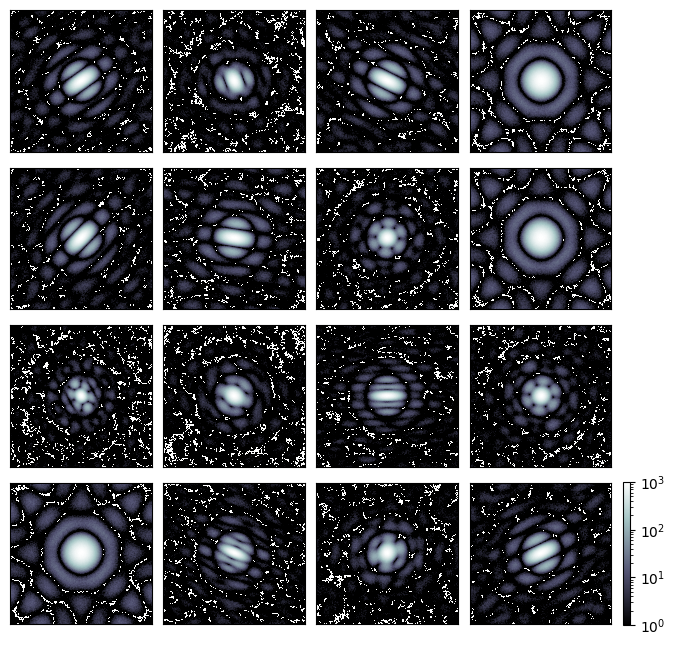

In [9]:
fig = plot_pattern_grid(diffs)

### Use ChatGPT to build a simple CNN that classifies images into 5 classes
#### ChatGPT Prompt:
Make a neural network model in PyTorch that classifies $N \times N$ grayscale images into 5 classes.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split, DataLoader, TensorDataset

torch.set_default_dtype(torch.float64)

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self, N):
        super(SimpleCNN, self).__init__()

        # Assuming grayscale image so input channels = 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=64 * (N//4) * (N//4), out_features=128)  # after two max-pooling layers
        self.fc2 = nn.Linear(in_features=128, out_features=5)  # 5 classes
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)

        x = self.relu(self.conv2(x))
        x = self.maxpool(x)

        x = x.view(x.size(0), -1)  # flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [12]:
model = SimpleCNN(N)
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=262144, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [13]:
# Format dataloaders
val_size = int(0.1 * num_images)
test_size = int(0.1 * num_images)
train_size = num_images - val_size - test_size
batch_size = 32

dataset = TensorDataset(torch.from_numpy(diffs).unsqueeze(1), torch.from_numpy(targets))
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### ChatGPT Prompt:
Write the training loop to optimize the CNN, which displays a progress bar and prints the current accuracy on the training and validation datasets for each epoch. Also save the training and validation losses and accuracies at each epoch to lists.

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN(N).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Progress bar with tqdm
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
    train_accuracy = correct_train / total_train
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Evaluate on validation data
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    print(f"Training Loss: {train_losses[-1]:.3f}, Training Accuracy: {train_accuracy*100:.2f}%,",
          f"Validation Loss: {val_losses[-1]:.3f}, Validation Accuracy: {val_accuracy*100:.2f}%\n")

Epoch 1/20: 100%|███████████████████████████████| 25/25 [00:05<00:00,  4.68it/s]


Training Loss: 23.285, Training Accuracy: 43.00%, Validation Loss: 0.839, Validation Accuracy: 66.00%



Epoch 2/20: 100%|███████████████████████████████| 25/25 [00:05<00:00,  4.69it/s]


Training Loss: 0.757, Training Accuracy: 65.88%, Validation Loss: 0.586, Validation Accuracy: 63.00%



Epoch 3/20: 100%|███████████████████████████████| 25/25 [00:05<00:00,  4.67it/s]


Training Loss: 0.627, Training Accuracy: 71.75%, Validation Loss: 0.483, Validation Accuracy: 77.00%



Epoch 4/20: 100%|███████████████████████████████| 25/25 [00:05<00:00,  4.67it/s]


Training Loss: 0.474, Training Accuracy: 80.00%, Validation Loss: 0.372, Validation Accuracy: 89.00%



Epoch 5/20: 100%|███████████████████████████████| 25/25 [00:05<00:00,  4.69it/s]


Training Loss: 0.433, Training Accuracy: 82.12%, Validation Loss: 0.455, Validation Accuracy: 80.00%



Epoch 6/20: 100%|███████████████████████████████| 25/25 [00:05<00:00,  4.72it/s]


Training Loss: 0.373, Training Accuracy: 84.75%, Validation Loss: 0.275, Validation Accuracy: 92.00%



Epoch 7/20: 100%|███████████████████████████████| 25/25 [00:05<00:00,  4.71it/s]


Training Loss: 0.296, Training Accuracy: 88.00%, Validation Loss: 0.281, Validation Accuracy: 89.00%



Epoch 8/20: 100%|███████████████████████████████| 25/25 [00:05<00:00,  4.69it/s]


Training Loss: 0.250, Training Accuracy: 90.38%, Validation Loss: 0.280, Validation Accuracy: 92.00%



Epoch 9/20: 100%|███████████████████████████████| 25/25 [00:05<00:00,  4.68it/s]


Training Loss: 0.248, Training Accuracy: 88.62%, Validation Loss: 0.411, Validation Accuracy: 86.00%



Epoch 10/20: 100%|██████████████████████████████| 25/25 [00:05<00:00,  4.68it/s]


Training Loss: 0.301, Training Accuracy: 86.62%, Validation Loss: 0.382, Validation Accuracy: 85.00%



Epoch 11/20: 100%|██████████████████████████████| 25/25 [00:05<00:00,  4.66it/s]


Training Loss: 0.206, Training Accuracy: 90.88%, Validation Loss: 0.252, Validation Accuracy: 89.00%



Epoch 12/20: 100%|██████████████████████████████| 25/25 [00:05<00:00,  4.66it/s]


Training Loss: 0.153, Training Accuracy: 94.00%, Validation Loss: 0.313, Validation Accuracy: 82.00%



Epoch 13/20: 100%|██████████████████████████████| 25/25 [00:05<00:00,  4.65it/s]


Training Loss: 0.148, Training Accuracy: 94.25%, Validation Loss: 0.534, Validation Accuracy: 70.00%



Epoch 14/20: 100%|██████████████████████████████| 25/25 [00:05<00:00,  4.66it/s]


Training Loss: 0.142, Training Accuracy: 94.25%, Validation Loss: 0.245, Validation Accuracy: 88.00%



Epoch 15/20: 100%|██████████████████████████████| 25/25 [00:05<00:00,  4.65it/s]


Training Loss: 0.124, Training Accuracy: 94.75%, Validation Loss: 0.248, Validation Accuracy: 87.00%



Epoch 16/20: 100%|██████████████████████████████| 25/25 [00:05<00:00,  4.64it/s]


Training Loss: 0.127, Training Accuracy: 95.62%, Validation Loss: 0.265, Validation Accuracy: 88.00%



Epoch 17/20: 100%|██████████████████████████████| 25/25 [00:05<00:00,  4.64it/s]


Training Loss: 0.112, Training Accuracy: 95.50%, Validation Loss: 0.193, Validation Accuracy: 92.00%



Epoch 18/20: 100%|██████████████████████████████| 25/25 [00:05<00:00,  4.64it/s]


Training Loss: 0.117, Training Accuracy: 95.50%, Validation Loss: 0.299, Validation Accuracy: 87.00%



Epoch 19/20: 100%|██████████████████████████████| 25/25 [00:05<00:00,  4.64it/s]


Training Loss: 0.102, Training Accuracy: 96.62%, Validation Loss: 0.251, Validation Accuracy: 90.00%



Epoch 20/20: 100%|██████████████████████████████| 25/25 [00:05<00:00,  4.64it/s]


Training Loss: 0.100, Training Accuracy: 95.50%, Validation Loss: 0.291, Validation Accuracy: 86.00%



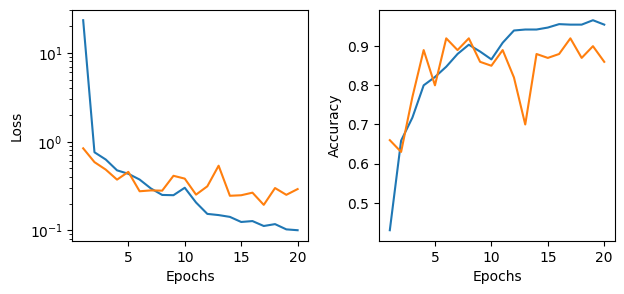

In [26]:
fig, ax = plt.subplots(1,2, figsize=(7,3))
fig.subplots_adjust(wspace=0.3)
ax[0].plot(range(1, len(train_losses) + 1), train_losses)
ax[0].plot(range(1, len(val_losses) + 1), val_losses)
ax[0].set_yscale('log')

ax[1].plot(range(1, len(train_accuracies) + 1), train_accuracies)
ax[1].plot(range(1, len(val_accuracies) + 1), val_accuracies)

ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy');